In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# 读取CSV数据
csv_path = Path("../../data/DM8006/interp1d_DM8006_data.csv")
df = pd.read_csv(csv_path)

In [4]:
# 将数据转换为torch tensor
# CSV列: time, u (目标位置), y (实际位置)
time_data = torch.tensor(df['time'].values, dtype=torch.float32)
des_dof_pos = torch.tensor(df['u'].values, dtype=torch.float32)
dof_pos = torch.tensor(df['y'].values, dtype=torch.float32)

des_dof_pos = des_dof_pos.unsqueeze(1)  # shape: [N, 1]
dof_pos = dof_pos.unsqueeze(1)  # shape: [N, 1]

print(f"time shape: {time_data.shape}")
print(f"des_dof_pos shape: {des_dof_pos.shape}")
print(f"dof_pos shape: {dof_pos.shape}")

time shape: torch.Size([15001])
des_dof_pos shape: torch.Size([15001, 1])
dof_pos shape: torch.Size([15001, 1])


In [5]:
# 保存为PT文件
output_dir = Path("../../data/DM8006")
output_dir.mkdir(parents=True, exist_ok=True)

output_path = output_dir / "chirp_data.pt"
torch.save({
    "time": time_data,
    "dof_pos": dof_pos,
    "des_dof_pos": des_dof_pos,
}, output_path)

print(f"数据已保存到: {output_path}")
print(f"文件大小: {output_path.stat().st_size / 1024:.2f} KB")

数据已保存到: ../../data/DM8006/chirp_data.pt
文件大小: 177.81 KB


图表已保存到: ../../data/DM8006/trajectory_comparison.png


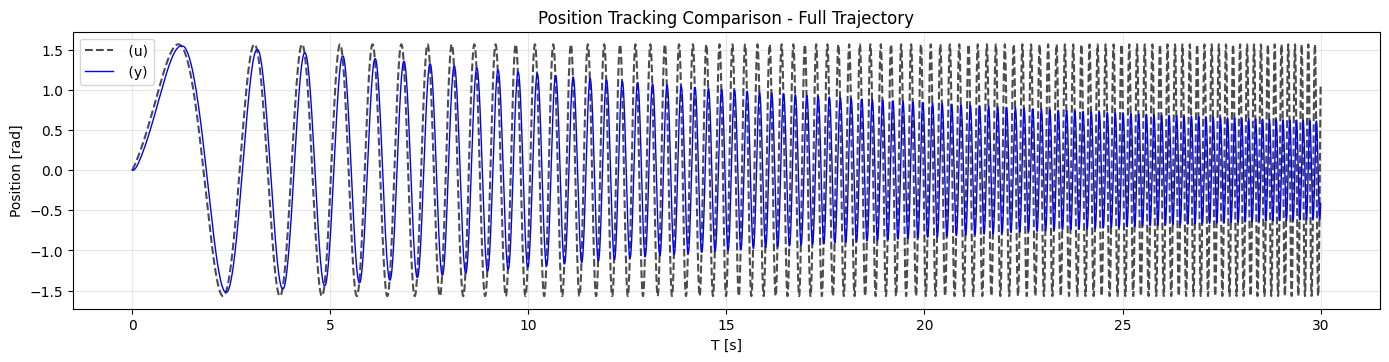

In [9]:
# 绘制完整轨迹对比图
plt.figure(figsize=(14, 10))

# 子图1: 位置对比（完整数据）
plt.subplot(3, 1, 1)
plt.plot(time_data.numpy(), des_dof_pos[:, 0].numpy(), 'k--', label=' (u)', linewidth=1.5, alpha=0.7)
plt.plot(time_data.numpy(), dof_pos[:, 0].numpy(), 'b-', label=' (y)', linewidth=1)
plt.xlabel('T [s]')
plt.ylabel('Position [rad]')
plt.title('Position Tracking Comparison - Full Trajectory')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../data/DM8006/trajectory_comparison.png', dpi=150, bbox_inches='tight')
print("图表已保存到: ../../data/DM8006/trajectory_comparison.png")
plt.show()